# Do not run

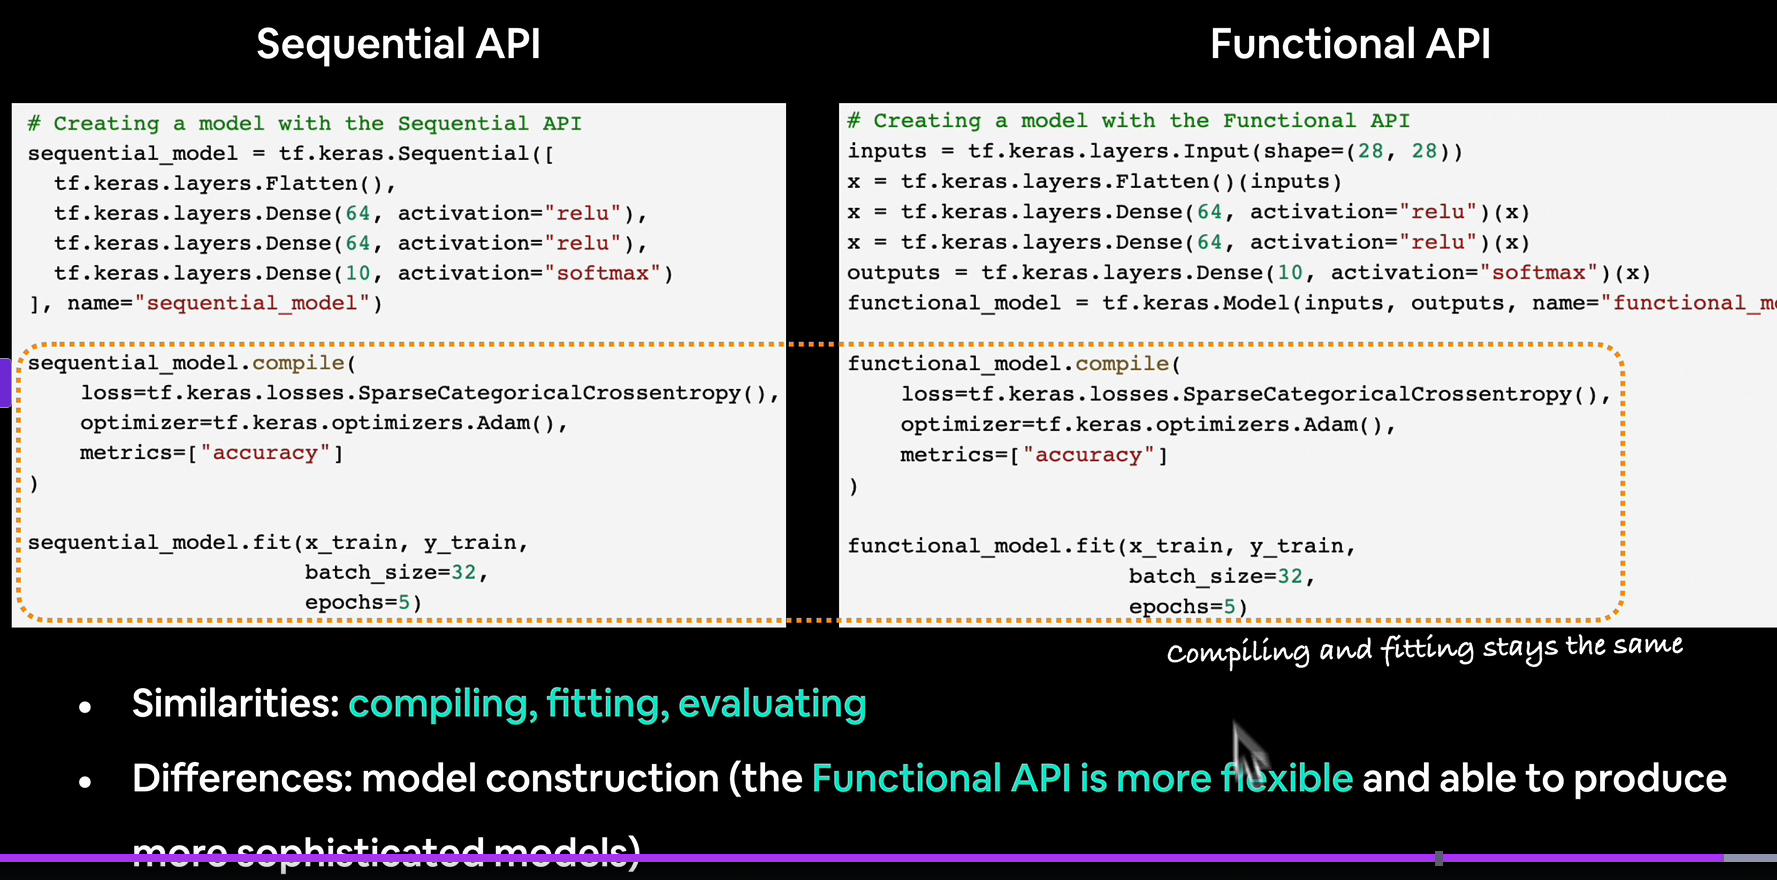

In [2]:
from IPython.display import Image
Image('/content/Screenshot 2025-05-30 201241.png')

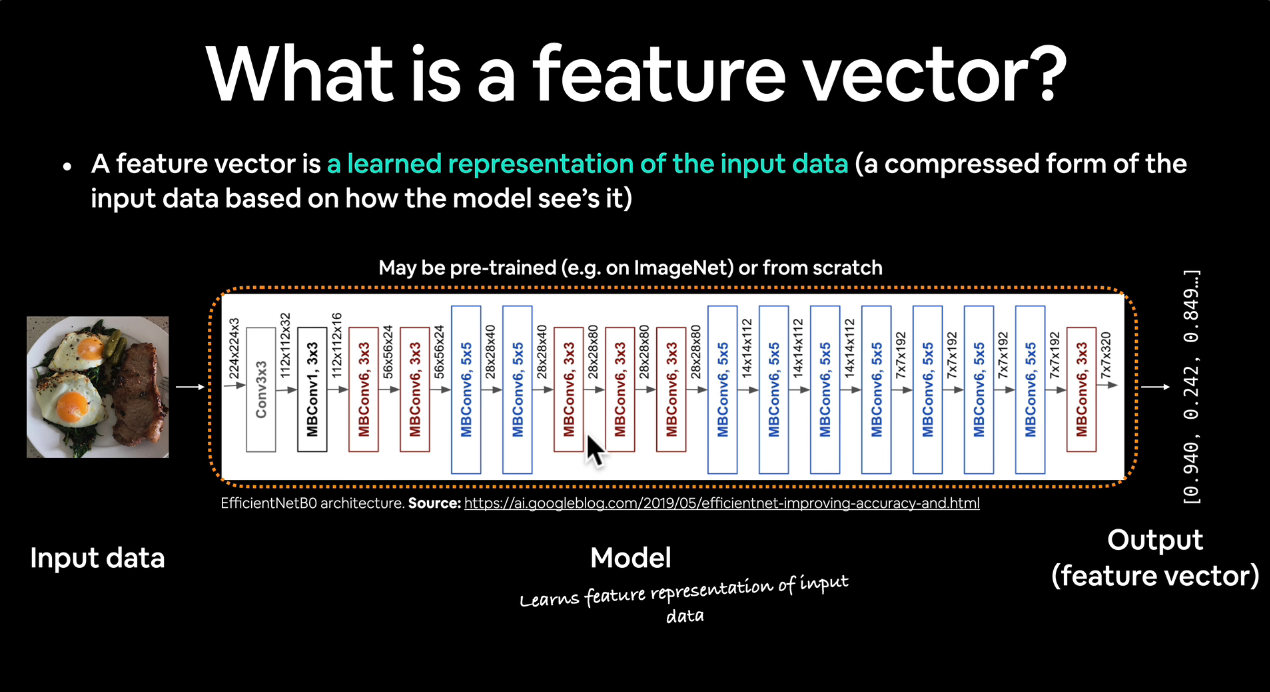

In [3]:
from IPython.display import Image
Image("/content/Screenshot 2025-06-01 082141.png")

# Transfer Learning with Tensorflow Part 2: Fine-Tuning

In the previous notebook,we covered transfer learning feature extraction, now its time to learn about a new kind of transfer learning: Fine-Tuning







In [4]:
# Check if we are using a gpu
!nvidia-smi

Sun Jun  1 15:19:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating Helper Functions
In previous  notebooks, we have created a bunch of helper functions,now we could rewrite them all,however,this is tedious.

So,its a good idea to functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere).

We've done this for some of the functions we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-06-01 15:19:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-01 15:19:33 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
# import helper functions we're going to use in this notebook.
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

>🔑**Note** : Since i am on google co-lab.When i reopen this file,the helper_functions.py will get deleted so to it back all i need to do is to re-run 2 cells above to get it back

## Let's get some data

This time we're goint to see how we can use the pre-trained models within `tf.keras.applications` and apply them to our own problem(recognizing image of food).
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [7]:
# Get 10% of training data of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the data
unzip_data("10_food_classes_10_percent.zip")

--2025-06-01 15:19:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   302MB/s    in 0.5s    

2025-06-01 15:19:38 (302 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [8]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [9]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             shear_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2)

In [11]:

'''
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               class_mode = "categorical",
                                               batch_size = 32,
                                               shuffle = False)
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             class_mode = "categorical",
                                             batch_size = 32,
                                             shuffle = False)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224,224),
                                                                   class_mode = "categorical",
                                                                   batch_size = 32,
                                                                   shuffle = False)
                                                                   '''
# Use helper function
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=IMG_SIZE,
                                                                  batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [13]:
#Check out the class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# See an example of a barch of data
for images,labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.64826523e+02 1.32826523e+02 1.19826530e+02]
   [1.66392853e+02 1.34392853e+02 1.21392853e+02]
   [1.62311218e+02 1.30311218e+02 1.17311226e+02]
   ...
   [1.65071487e+02 1.41071487e+02 1.30642960e+02]
   [1.62785721e+02 1.38785721e+02 1.28785721e+02]
   [1.66999924e+02 1.42999924e+02 1.32999924e+02]]

  [[1.63872452e+02 1.29872452e+02 1.17872444e+02]
   [1.61224487e+02 1.27224487e+02 1.15224487e+02]
   [1.58270401e+02 1.24270409e+02 1.12270409e+02]
   ...
   [1.67214355e+02 1.43214355e+02 1.32785828e+02]
   [1.64862259e+02 1.40862259e+02 1.30862259e+02]
   [1.69142792e+02 1.45142792e+02 1.35142792e+02]]

  [[1.65862244e+02 1.31862244e+02 1.19862244e+02]
   [1.63663269e+02 1.29663269e+02 1.17663269e+02]
   [1.64352036e+02 1.30352036e+02 1.18352043e+02]
   ...
   [1.64000061e+02 1.39357208e+02 1.29142960e+02]
   [1.61515320e+02 1.36872467e+02 1.27086754e+02]
   [1.65928497e+02 1.41285645e+02 1.31499924e+02]]

  ...

  [[1.74571411e+02 1.42571411e+02 1.29571411e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [15]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information and reduce no of computation )
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax",name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning",experiment_name="feature_extraction")])

Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/feature_extraction/20250601-151943
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2694 - loss: 2.1079 - val_accuracy: 0.7023 - val_loss: 1.3221
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.7460 - loss: 1.2273 - val_accuracy: 0.8257 - val_loss: 0.8906
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8192 - loss: 0.8692 - val_accuracy: 0.8553 - val_loss: 0.7106
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8521 - loss: 0.6788 - val_accuracy: 0.8750 - val_loss: 0.6059
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8736 - loss: 0.5995 - val_accuracy: 0.8684 - val_loss: 0.5640


In [16]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8669 - loss: 0.5634


[0.5728390216827393, 0.857200026512146]

In [17]:
# Check the layers in base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer)

0 <InputLayer name=input_layer, built=True>
1 <Rescaling name=rescaling, built=True>
2 <Normalization name=normalization, built=True>
3 <Conv2D name=stem_conv, built=True>
4 <BatchNormalization name=stem_bn, built=True>
5 <Activation name=stem_activation, built=True>
6 <Conv2D name=block1a_project_conv, built=True>
7 <BatchNormalization name=block1a_project_bn, built=True>
8 <Activation name=block1a_project_activation, built=True>
9 <Conv2D name=block2a_expand_conv, built=True>
10 <BatchNormalization name=block2a_expand_bn, built=True>
11 <Activation name=block2a_expand_activation, built=True>
12 <Conv2D name=block2a_project_conv, built=True>
13 <BatchNormalization name=block2a_project_bn, built=True>
14 <Conv2D name=block2b_expand_conv, built=True>
15 <BatchNormalization name=block2b_expand_bn, built=True>
16 <Activation name=block2b_expand_activation, built=True>
17 <Conv2D name=block2b_project_conv, built=True>
18 <BatchNormalization name=block2b_project_bn, built=True>
19 <Dropout 

In [18]:
# Summary of base model
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [19]:
# How about a summary of our whole model
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

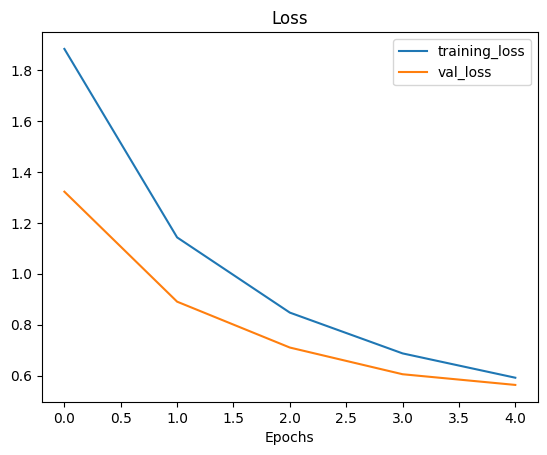

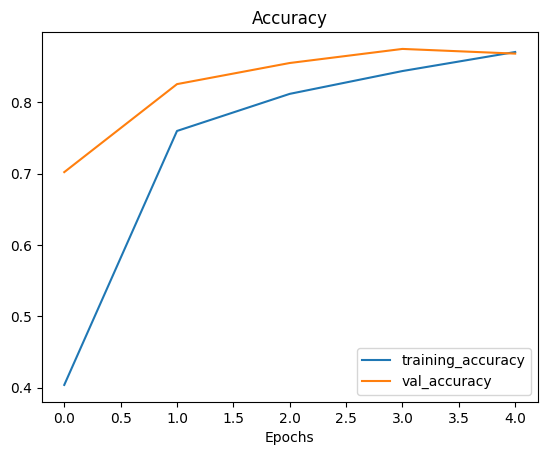

In [20]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demosntrate the global average pooling 2D layer ....

We have a tensor after out model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through global average pooling 2d, it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [21]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Input tensor:\n {input_tensor}\n")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"output tensor: {global_average_pooled_tensor}")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of output tensor: {global_average_pooled_tensor.shape}")

Input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

output tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of output tensor: (1, 3)


In [22]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor,axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Input tensor:\n {input_tensor}\n")

global_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"output tensor: {global_pooled_tensor}")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of output tensor: {global_pooled_tensor.shape}")

Input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

output tensor: [[0.9058464 1.1603122 1.6994323]]
Shape of input tensor: (1, 4, 4, 3)
Shape of output tensor: (1, 3)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10 % of the training data, but how does it go with 1 % of the training data ... how about we set up a bunch of experiments to find out :

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine - tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine - tuning transfer learning on 100% of the training data with data augmentation
> **Note** : Keep test data same for consistent evaluation metrics

## Getting and preprocessing data for model_1

In [24]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2025-06-01 15:21:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   337MB/s    in 0.4s    

2025-06-01 15:21:45 (337 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [25]:
# Create training and test data
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [26]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There a

In [27]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers...`

Previously we've used the different parameters of the ImageDataGenerator class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the `tf.keras.layers` module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

- Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
- Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Create data augmentation stage with horizontal flipping,rotations,zooms etc
data_augmentation = keras.Sequential([
    layers.Resizing(224, 224),        # 👈 Ensure input matches base model size
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.) keep for model like ResNet50V2
],name = "data_augmentation")

# Model 1 : Feature extraction transfer learning on 1 % of the data with data augmentation


In [29]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3) # or IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,input_shape = input_shape)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape = input_shape,name = "input_layer")

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x,training = False)

# Pool the outputs of the base model (aggregate all the most important information and reduce no of computation )
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a Dense layer on as the output
outputs = layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# Make a model using inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

# Compile it
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit it
history_1 = model_1.fit(train_data_1_percent,
            epochs = 5,
            steps_per_epoch = len(train_data_1_percent),
            validation_data = test_data,
            validation_steps = int(0.25*len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                      experiment_name = "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250601-152148
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.1073 - loss: 2.4079 - val_accuracy: 0.1924 - val_loss: 2.1384
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 897ms/step - accuracy: 0.1866 - loss: 2.1730 - val_accuracy: 0.3092 - val_loss: 2.0524
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3739 - loss: 2.0183 - val_accuracy: 0.3832 - val_loss: 1.9420
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4070 - loss: 1.9101 - val_accuracy: 0.4309 - val_loss: 1.8783
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.5449 - loss: 1.7974 - val_accuracy: 0.4688 - val_loss: 1.7998


In [30]:
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [31]:
# Evaluate on full test dataset
model_1.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4558 - loss: 1.8252


[1.815521240234375, 0.4691999852657318]

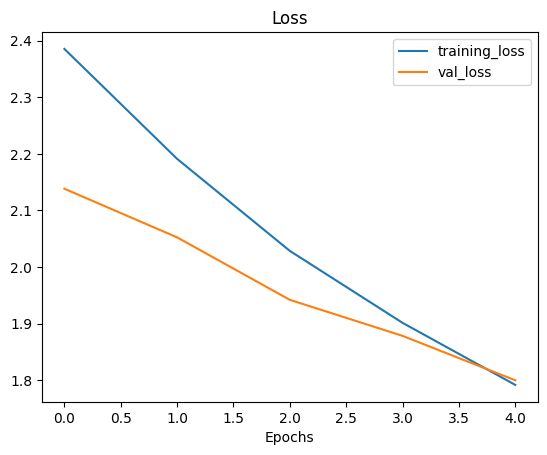

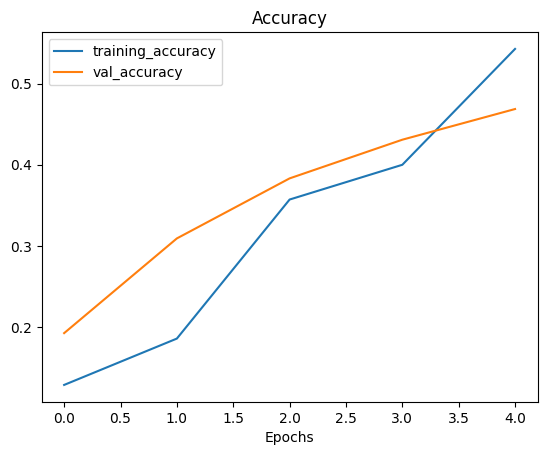

In [32]:
# How do the model with 1% of the data augmentation loss curve looks ?
plot_loss_curves(history_1)

## Model 2 : feature extraction tansfer leanring model with 10% of training data and data augmentation

In [33]:
# Get data (already done for 10 %)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [34]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# Create data augmentation layer for model 2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Build data augmentation layer
data_aug = Sequential([
    layers.Resizing(224,224),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
],name = "data_augmentation_layer")

In [36]:
# Create model_2

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")

x = data_aug(inputs) # Augement our train data

x = base_model(x,training = False) # pass augmented images to base model but keep it in inference mode,this also insures batchnorm layers don't get updated.

x = layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)

outputs = layers.Dense(10,activation = "softmax",name = "output_layer")(x)

model_2 = tf.keras.Model(inputs,outputs)

# Compile it

model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit it

history_2 = model_2.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "10_percent_data_aug"))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250601-152244
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.2356 - loss: 2.1996 - val_accuracy: 0.7007 - val_loss: 1.4190
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.6641 - loss: 1.4195 - val_accuracy: 0.7928 - val_loss: 0.9908
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.7534 - loss: 1.0438 - val_accuracy: 0.8059 - val_loss: 0.8075
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7705 - loss: 0.8762 - val_accuracy: 0.8289 - val_loss: 0.6795
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8328 - loss: 0.7312 - val_accuracy: 0.8405 - val_loss: 0.6157


In [37]:
res_2 = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8377 - loss: 0.6263


[0.6177765130996704, 0.8435999751091003]

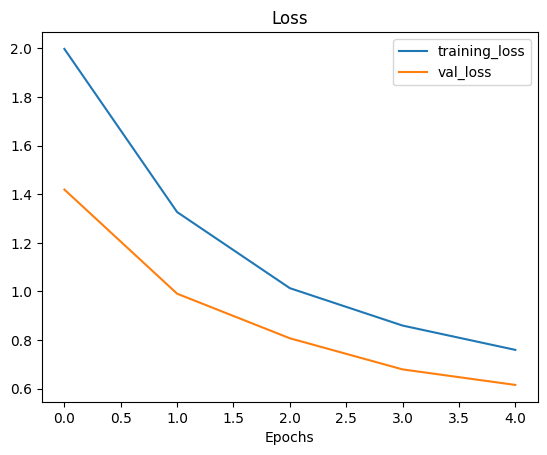

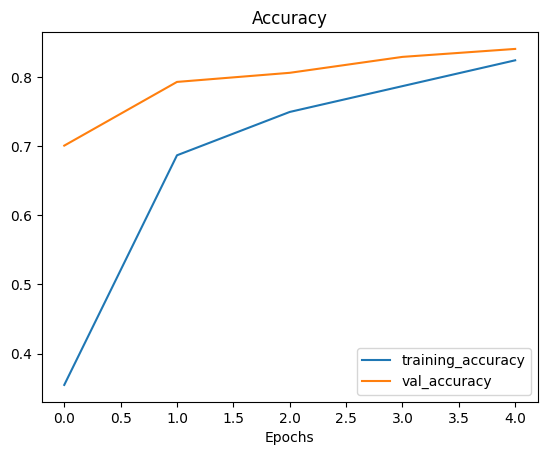

In [38]:
plot_loss_curves(history_2)

In [39]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

### Creating a Model Checkpointing Callback : `tf.keras.callbacks.ModelCheckpoint()`

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [40]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = True,
                                                         save_freq = "epoch", # Every epoch
                                                         verbose = 1)

In [41]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name ="transfer_learning",
                                                                                   experiment_name ="10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250601-152340
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8459 - loss: 0.7371
Epoch 1: val_loss improved from inf to 0.58912, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8458 - loss: 0.7361 - val_accuracy: 0.8454 - val_loss: 0.5891
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8355 - loss: 0.6728
Epoch 2: val_loss improved from 0.58912 to 0.57229, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8355 - loss: 0.6717 - val_accuracy: 0.8339 - val_loss: 0.5723
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8429 - loss: 0.5959
Epoch 3: val_loss improved from 0.57229 to 0.52804, saving model to ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - a

In [52]:
res_2 = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8509 - loss: 0.5030


In [43]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8547 - loss: 0.5793


[0.5728391408920288, 0.857200026512146]

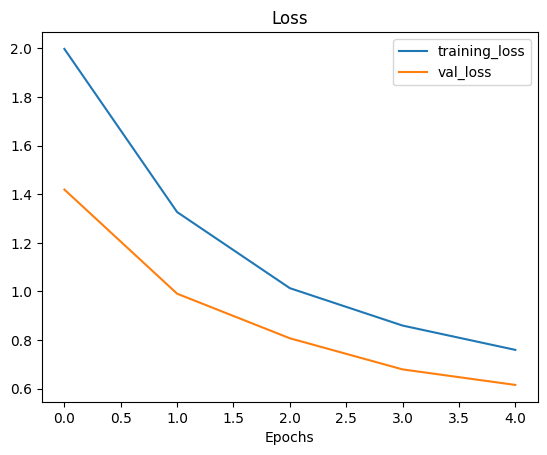

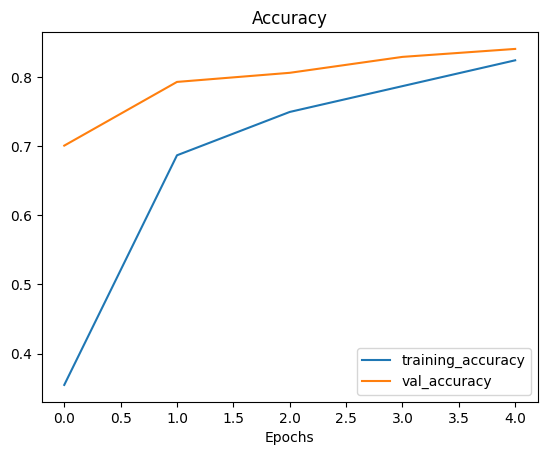

In [44]:
plot_loss_curves(history_2)

### Loading in a checkpointed weights

Loading a checkpointed weights  returns a model to a specified checkpoint.


In [45]:
model_2.load_weights(checkpoint_path)

In [49]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results  = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8497 - loss: 0.4991


In [53]:
loaded_weights_model_results == res_2

True

In [54]:
import numpy as np
np.isclose(np.array(loaded_weights_model_results),np.array(res_2))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

> ** Note ** : Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amount of custom data

In [55]:
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation_layer, built=True>,
 <Functional name=efficientnetb0, built=True>,
 <GlobalAveragePooling2D name=Global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [56]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer,layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation_layer, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=Global_average_pooling_layer, built=True> True
<Dense name=output_layer, built=True> True


In [62]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_layer_3 False
1 rescaling_2 False
2 normalization_2 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [63]:
# How many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [66]:
# To began fine-tuning ,lets start by setting the last 10 layers of our base_mode.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine - tuning you typically wanna lower your learning rate by 10x
                metrics=["accuracy"])

> **Note:** Every time you make a change to your models, you need to recompile them.

  * In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

  * We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

In [67]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer,layer.trainable)

0 <InputLayer name=input_layer_3, built=True> False
1 <Rescaling name=rescaling_2, built=True> False
2 <Normalization name=normalization_2, built=True> False
3 <Rescaling name=rescaling_3, built=True> False
4 <ZeroPadding2D name=stem_conv_pad, built=True> False
5 <Conv2D name=stem_conv, built=True> False
6 <BatchNormalization name=stem_bn, built=True> False
7 <Activation name=stem_activation, built=True> False
8 <DepthwiseConv2D name=block1a_dwconv, built=True> False
9 <BatchNormalization name=block1a_bn, built=True> False
10 <Activation name=block1a_activation, built=True> False
11 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
12 <Reshape name=block1a_se_reshape, built=True> False
13 <Conv2D name=block1a_se_reduce, built=True> False
14 <Conv2D name=block1a_se_expand, built=True> False
15 <Multiply name=block1a_se_excite, built=True> False
16 <Conv2D name=block1a_project_conv, built=True> False
17 <BatchNormalization name=block1a_project_bn, built=True> False
18 <C

In [68]:
# How many trainable variables
print(len(model_2.trainable_variables))

12


In [73]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5
history_fine = model_2.fit(train_data_10_percent,
                           epochs = fine_tune_epochs,
                           validation_data = test_data,
                           validation_steps = int(0.25*len(test_data)),
                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                           callbacks = create_tensorboard_callback(dir_name = "transfer_learning",
                                                                   experiment_name = "10_percent_fine_tune_last_10"))

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250601-155703
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9332 - loss: 0.3410 - val_accuracy: 0.8520 - val_loss: 0.4064
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9194 - loss: 0.3512 - val_accuracy: 0.8651 - val_loss: 0.3856
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9344 - loss: 0.2830 - val_accuracy: 0.8635 - val_loss: 0.3853
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9345 - loss: 0.2721 - val_accuracy: 0.8651 - val_loss: 0.3754
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.9442 - loss: 0.2499 - val_accuracy: 0.8586 - val_loss: 0.3863
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9583 - loss: 0.2402 - val_accuracy: 0.8635 - val_loss: 0.3758


In [74]:
# Evaluate the fine-tuned model
res_3 = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8680 - loss: 0.3727


In [75]:
res_2

[0.4882170855998993, 0.8611999750137329]

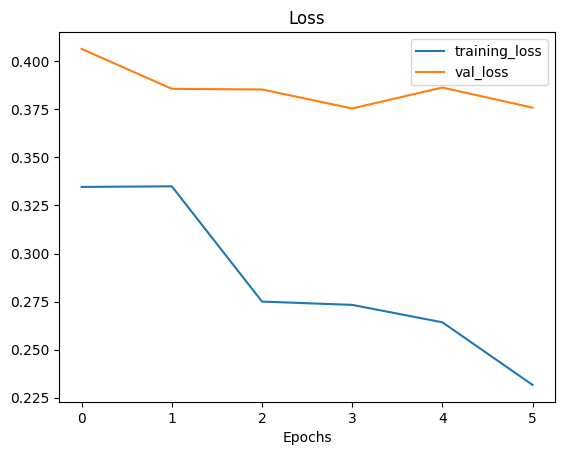

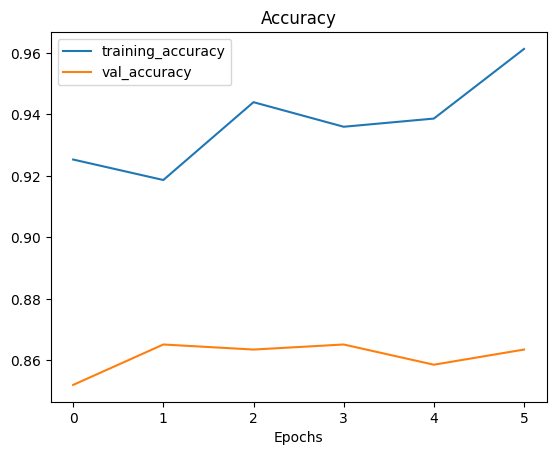

In [76]:
plot_loss_curves(history_fine)

The `plot_loss_curves` function works great with models which have only been fit once, however we want something to compare one series of running `fit()` with another (i.e before and after fine-tuning)

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history,new_history,initial_epoch = 5):
  """
  Compares two TensorFlow History objects.

  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label = "Training Accuracy")
  plt.plot(total_val_acc,label = "Validation Accuracy")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss,label = "Training Loss")
  plt.plot(total_val_loss,label = "Validation Loss")
  plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

In [ ]:
compare_histories(history_10_percent_data_aug,history_fine,initial_epoch = 5)

## Model 4 : Fine - tuning existing model and all of the data (use of 100% as train data)

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [ ]:
walk_through_dir("10_food_classes_all_data")

In [ ]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMG_SIZE,
                                                                  batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = 32)


In [ ]:
data_augmentation_100_percent = Sequential([
    layers.Resizing(224,224),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
],name = "data_augmentation_layer")

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10% data model was fine-tuned from.
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction TL model for 5 epochs on 10% of the data wiht data augmentation(model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine - tuned the same model on the same 10 % of the data for futher 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all the data

In [ ]:
# Check which layers are trainable in the whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_no.layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

In [ ]:
# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])


In [ ]:
# Continue to train and fine-tune the model to our data (100% data)
fine_tune_epochs = initial_epochs + 5

history_fine_100_percent = model_2.fit(train_data_100_percent,
                                        epochs = fine_tune_epochs,
                                        validation_data = test_data,
                                        validation_steps = int(0.25*len(test_data)),
                                        initial_epoch = history_fine.epoch[-1],
                                        callbacks = create_tensorboard_callback(dir_name = "transfer_learning",
                                                                             experiment_name = "100_percent_fine_tune_last_10"))


In [ ]:
res_4 = model_2.evaluate(test_data)
res_4

In [ ]:
# How did fine-tuning go with more data ?
compare_histories(history_fine,history_fine_100_percent,initial_epoch = 5)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

In [ ]:

# # View all of your uploaded TensorBoard.dev experiments (public)
# !tensorboard dev list

In [ ]:
# # To delete an experiment
# !tensorboard dev delete --experiment_id vcySzjmkRkKBLVSdAQMO8g # Change this for the experiment ID you want to delete
